<a href="https://colab.research.google.com/github/shubhamitradas/Toxicity-Challenge/blob/master/clip_signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Document Image Search.

This notebook shows how we can use the zero shot capabilities of **OpenAI's CLIP** model to find out images from a document without any finetuning.


**Steps**:
1. Download and run CLIP models.
2. Calculate the similarity between text inputs and images retrieved from the document.Here we focus on **Handwritten Signatures and Notary Seal.**
3.Perform zero-shot image classifications.







# Preparation for Colab

Make sure we are running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pdf2image
!apt-get install poppler-utils 

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu101


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

Here ViT-B/32 is used for this notebook.

In [3]:
import clip
clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:


# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)




100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 174MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Load the sample document from Google Drive.


In [5]:
def list_folder(folder_id):
    # folder_id: GoogleDriveFile['id']
    _q = {'q': "'{}' in parents and trashed=false".format(folder_id)}
    return drive.ListFile(_q).GetList()

  # Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
listed = drive.ListFile({'q': "title contains 'sample.pdf' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title sample.pdf, id 1Wms56S5nKFj06ikFMRrqnAKJspRc9sT-


In [6]:
downloaded = drive.CreateFile({'id':'1Wms56S5nKFj06ikFMRrqnAKJspRc9sT-'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('sample.pdf') 

# Convert each page of the PDF document to a .jpg file.

In [7]:
!mkdir images features

In [8]:
import os
from pdf2image import convert_from_path

pdf_dir = r"/content/"
os.chdir(pdf_dir)

for pdf_file in os.listdir(pdf_dir):

    if pdf_file.endswith(".pdf"):

            pages = convert_from_path(pdf_file, 300)
            pdf_file = pdf_file[:-4]

            for page in pages:

               page.save("%s-page%d.jpg" % (pdf_file,pages.index(page)), "JPEG")

In [9]:
!mv *.jpg images/

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

In [10]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f517a3bb950>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#Process the images(each page) obtained from the document.

Now we need to compute the features for all pages of the document.
We will do that in batches, because it is much more efficient. 

In this step the feature vectors and the picture IDs of each batch will be saved to a file separately. This makes the whole process more robust. We will merge the data later.

In [11]:

from PIL import Image


# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [12]:
import math
import numpy as np
import pandas as pd
from pathlib import Path

# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = 16
photos_path = Path("/content/images/")
print(photos_path)

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))


# Path where the feature vectors will be stored
features_path = Path("/content/") / "features"

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)


# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

/content/images
Processing batch 1/6
Processing batch 2/6
Processing batch 3/6
Processing batch 4/6
Processing batch 5/6
Processing batch 6/6


#Merge the features and the photo IDs. 

The resulting files are features.npy and photo_ids.csv

In [13]:
import numpy as np
import pandas as pd


# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

 # Search for photos using natural language query.

* The search query is encoded to a feature vector using CLIP.
* Compare the text features to the pre-computed image features using Cosine similarity and find the best match.
* Sort the photos by their similarity score
* Display the top K match.


In [21]:
from IPython.display import Image
from IPython.core.display import HTML
from pdf2image import convert_from_bytes

def show_images(search_query,num_images):

  with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the description vector and the photo vectors
  text_features = text_encoded.cpu().numpy()

  photo_features = np.load(features_path / "features.npy")
  photo_ids = pd.read_csv(features_path / "photo_ids.csv")
  photo_ids = list(photo_ids['photo_id'])

  # Compute the similarity between the descrption and each photo using the Cosine similarity
  similarities = list((text_features @ photo_features.T).squeeze(0))

  # Sort the photos by their similarity score
  best_photos = sorted(zip(similarities, range(photo_features.shape[0])), key=lambda x: x[0], reverse=True)

  # Iterate over the top 3 results
  for i in range(num_images):
    # Retrieve the photo ID
    idx = best_photos[i][1]
    photo_id = photo_ids[idx]
    image_path = Path("/content/images") / photo_id / ".jpg"
    dir_name = "/content/images"
    base_filename = photo_id
    filename_suffix = "jpg"
    filename = os.path.join(dir_name, base_filename + "." + filename_suffix)
    print(filename)



    display(Image(filename,width = 400, height = 400))
    # Display the photo


/content/images/sample-page41.jpg


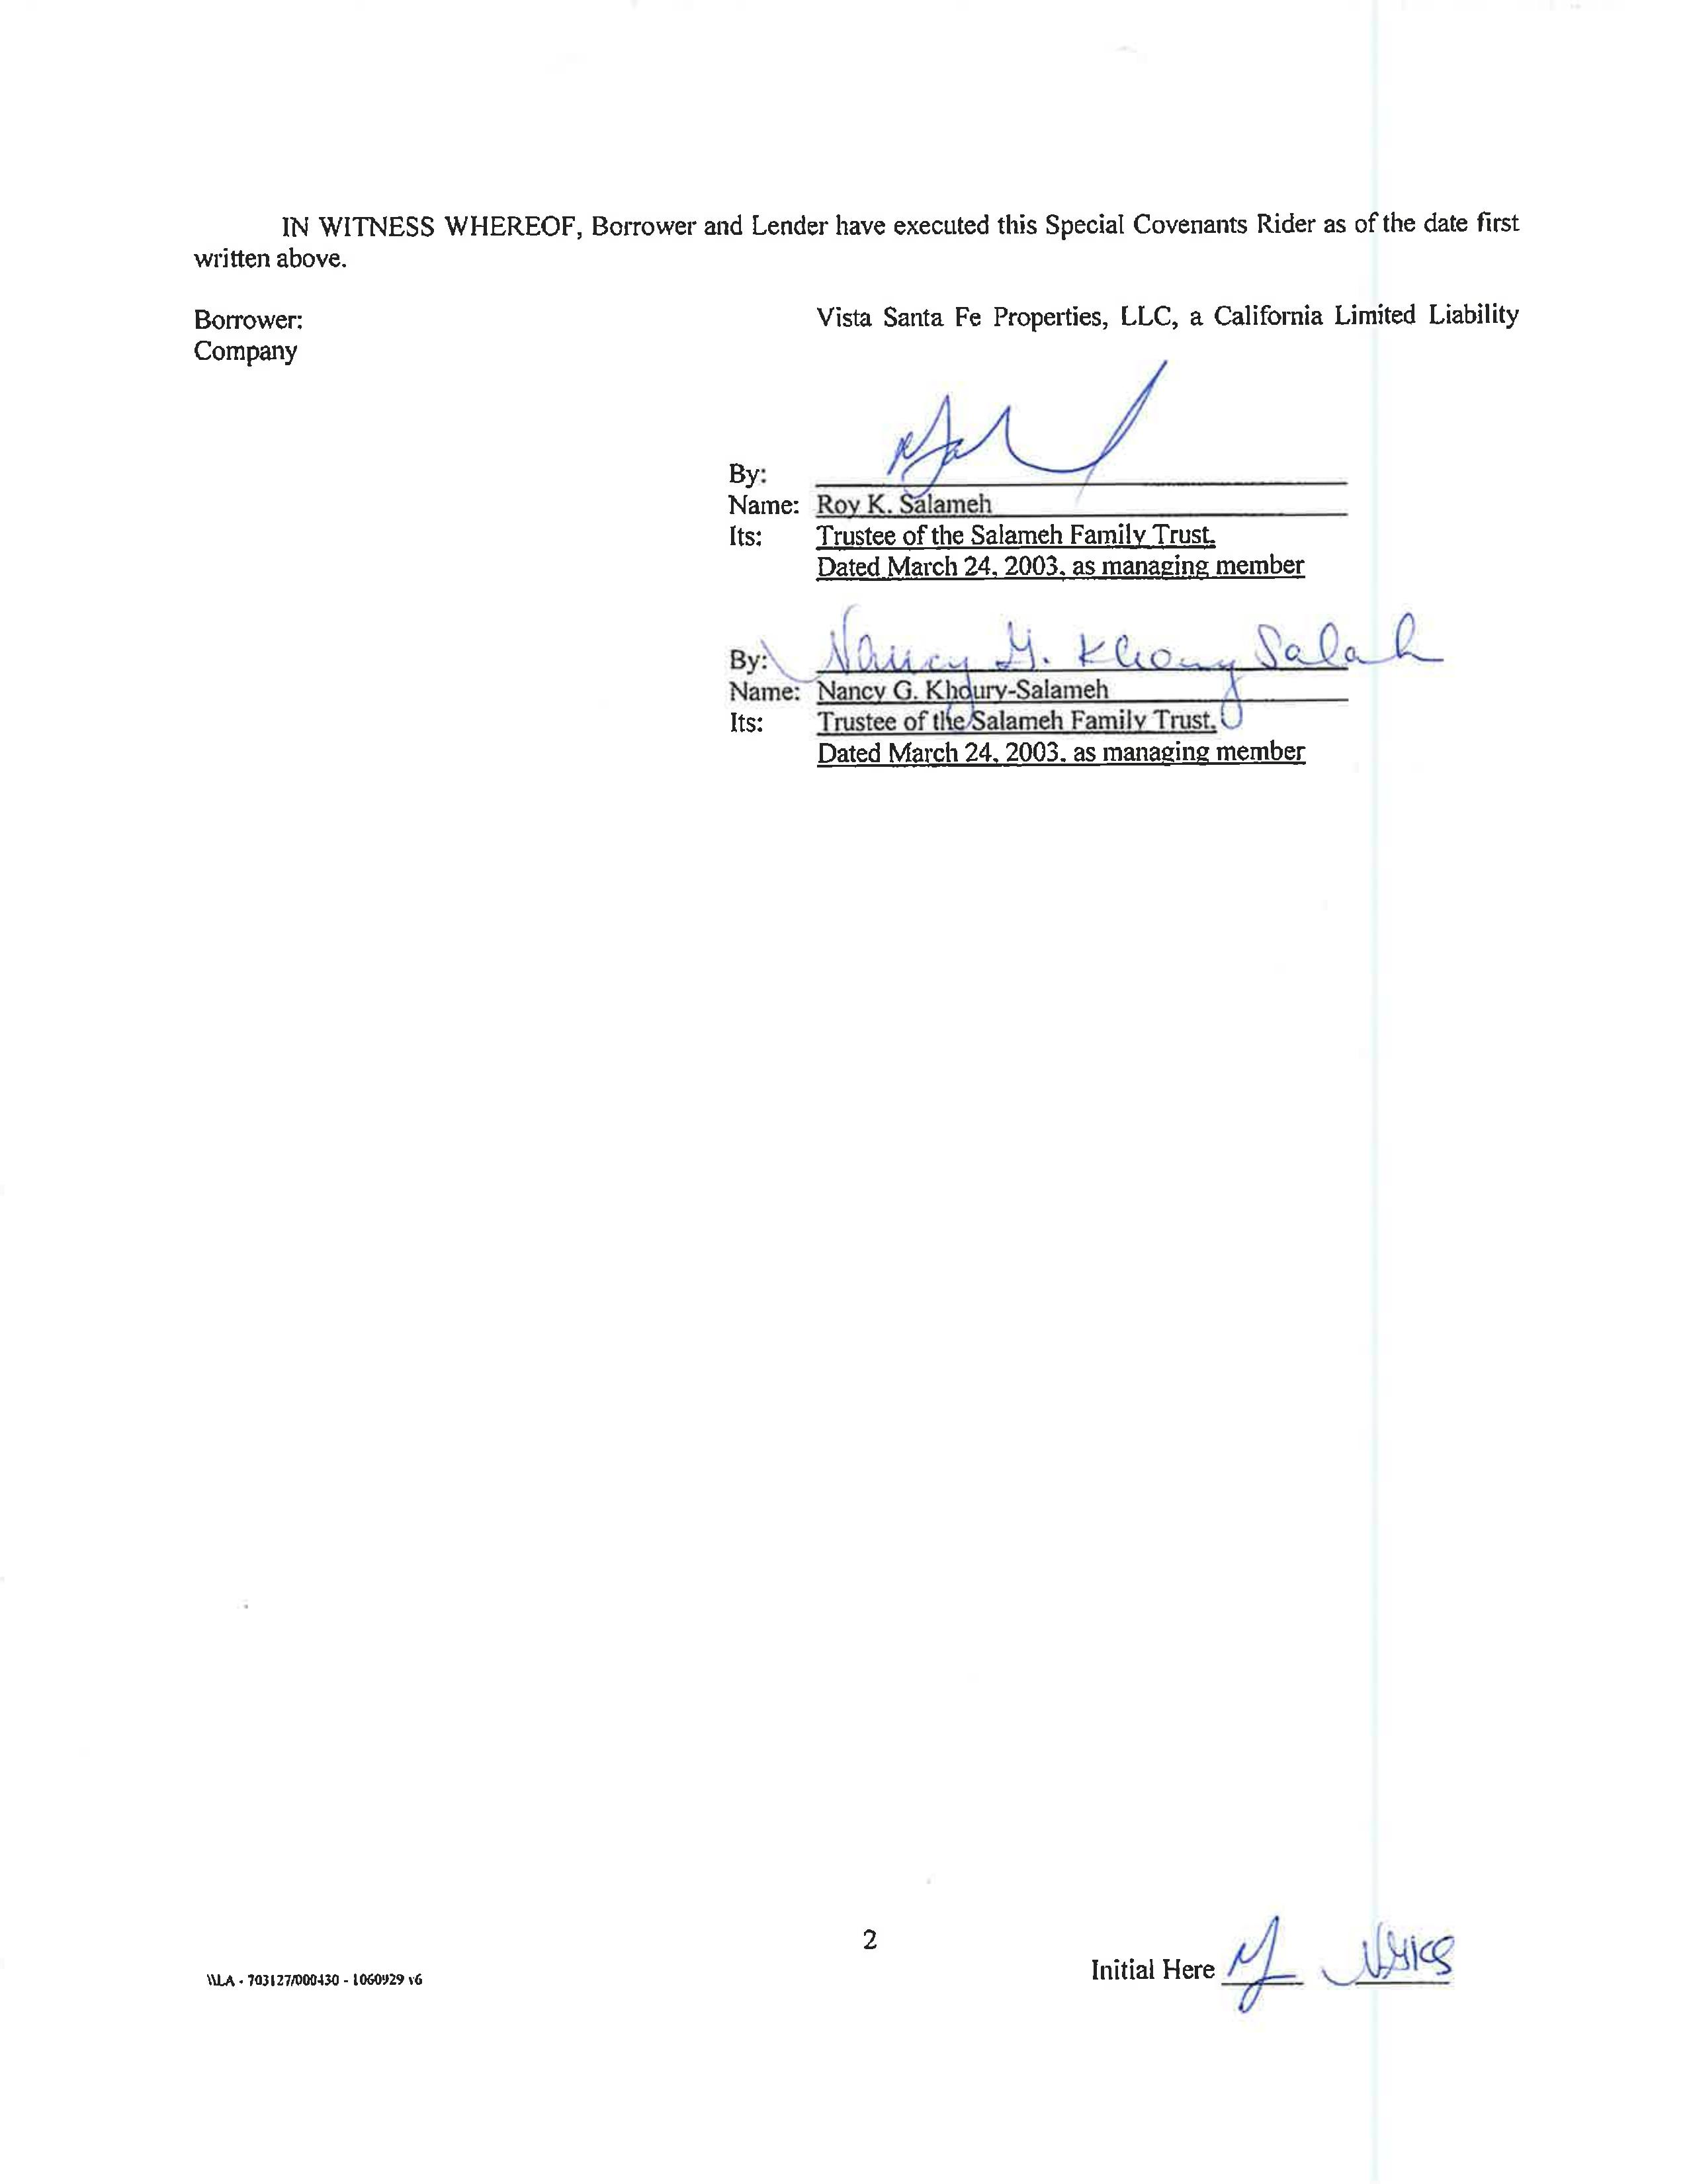

/content/images/sample-page45.jpg


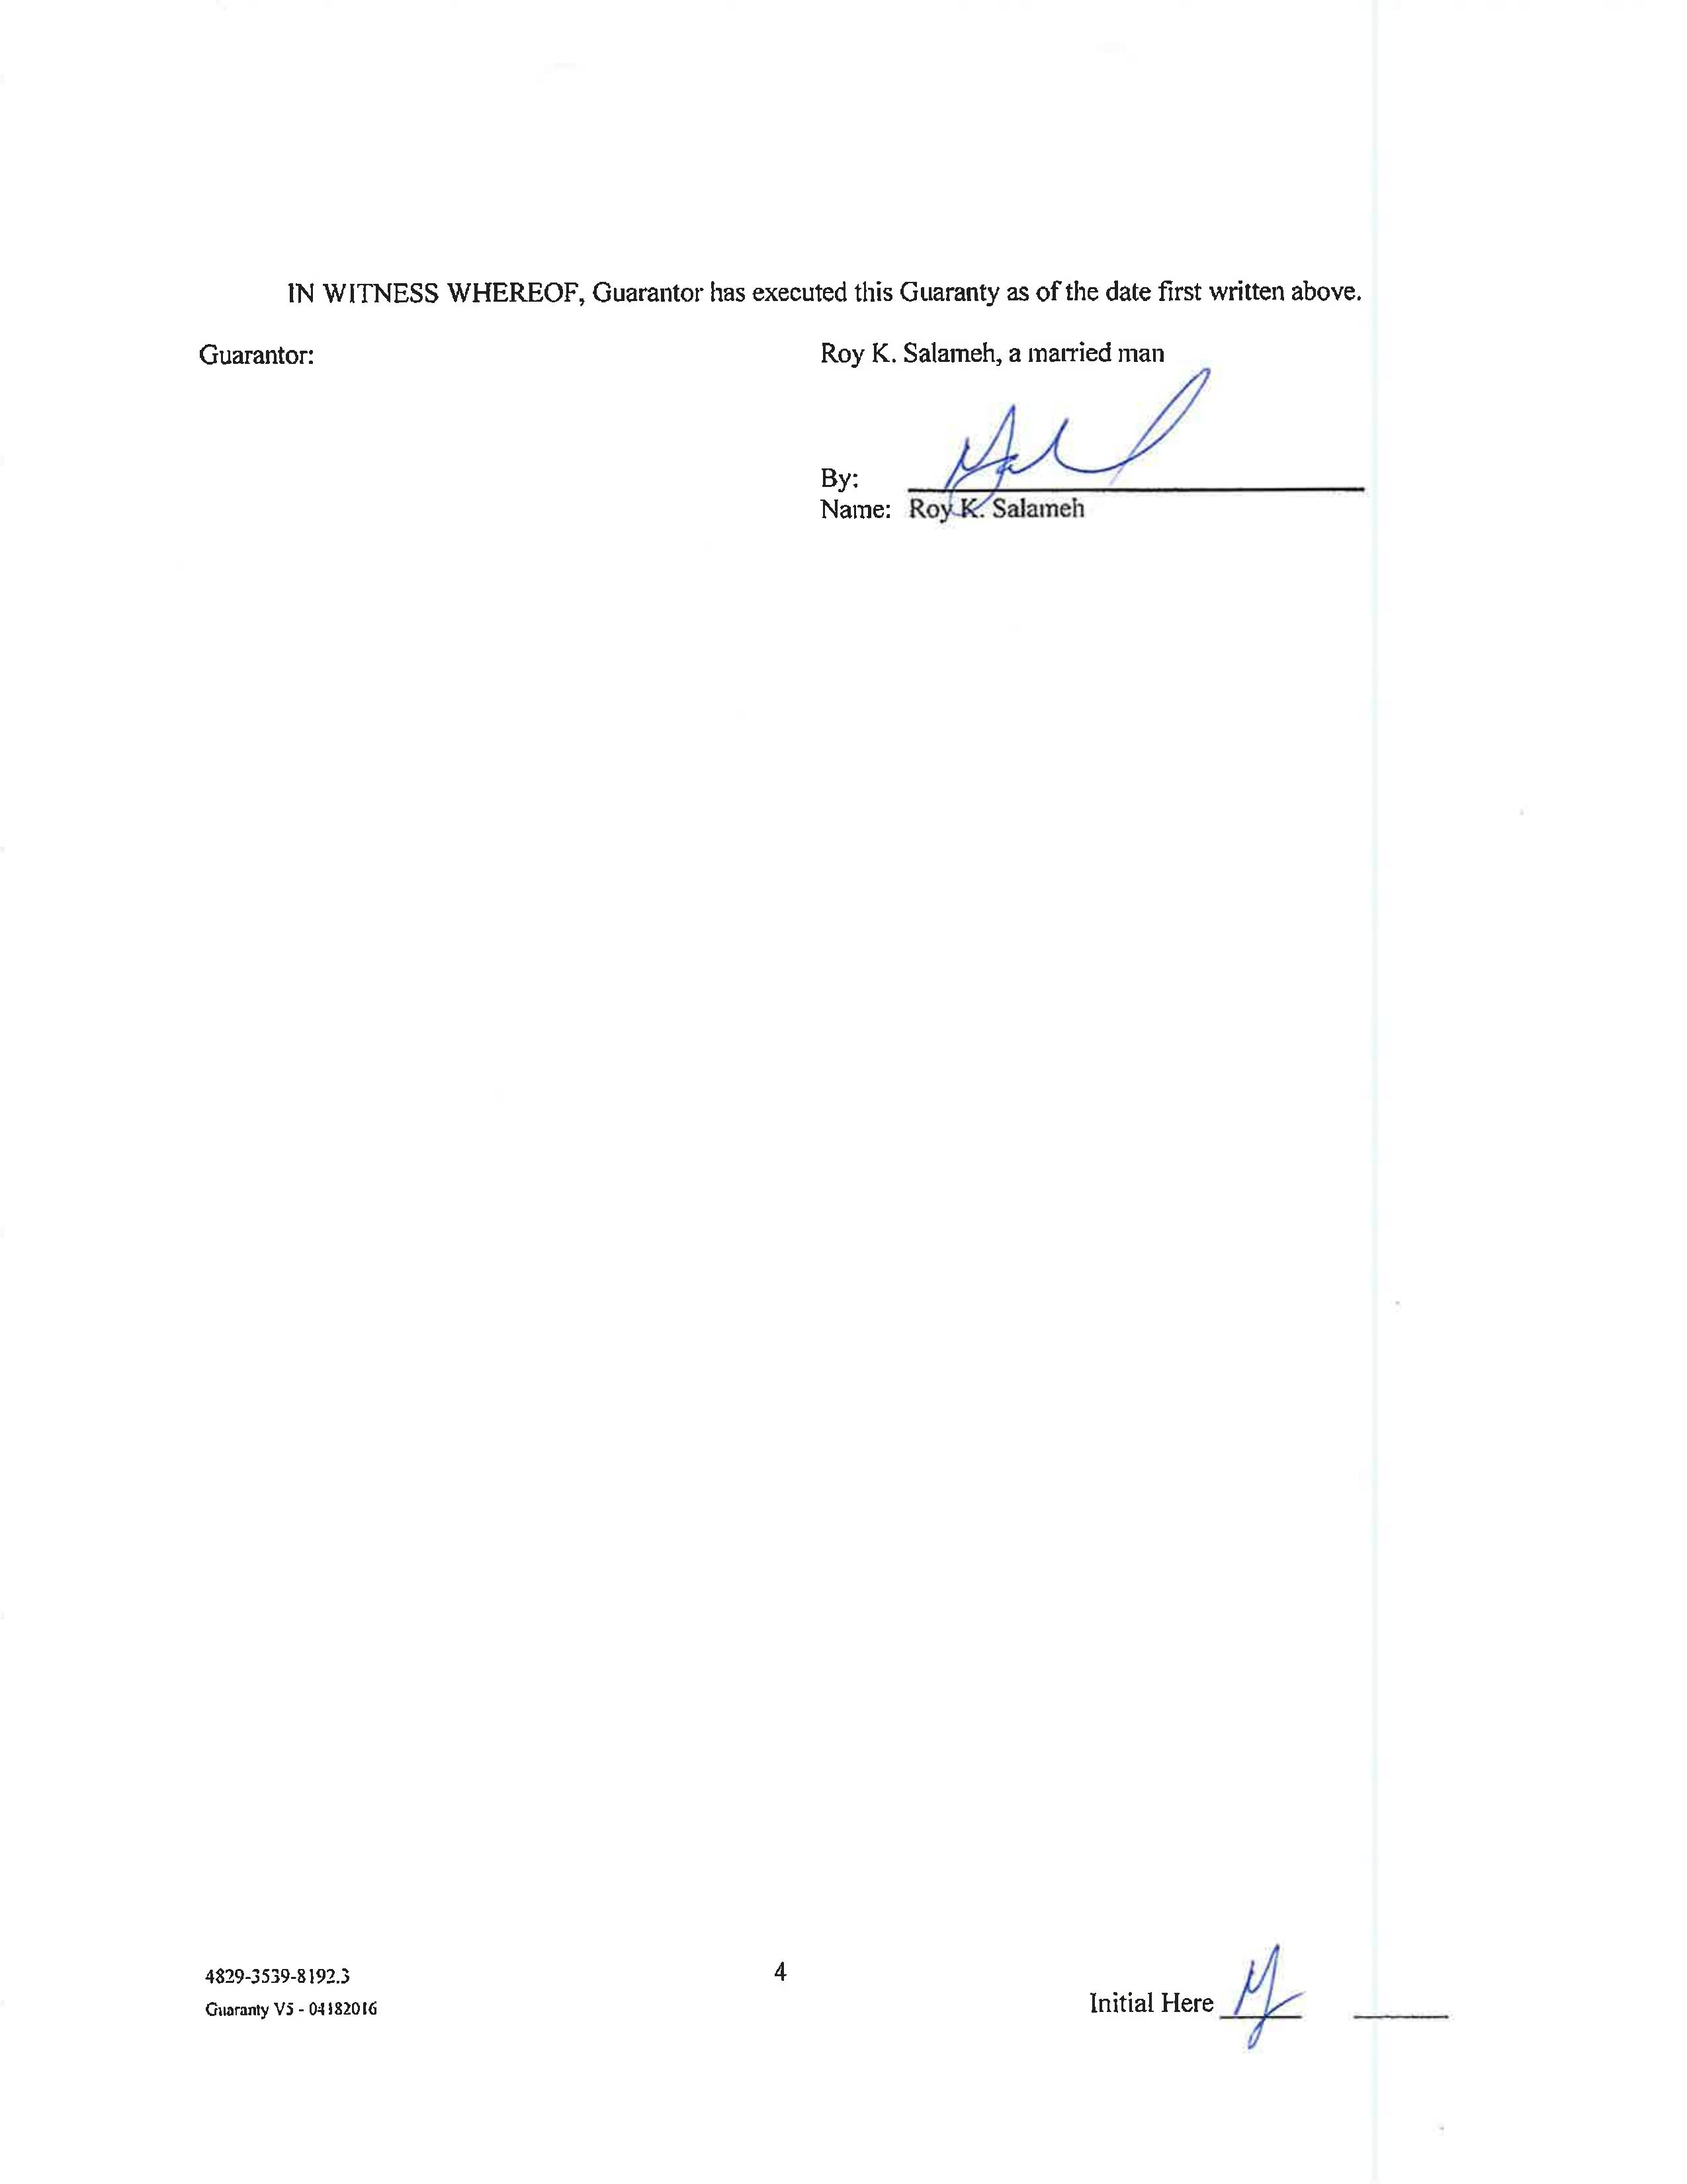

/content/images/sample-page3.jpg


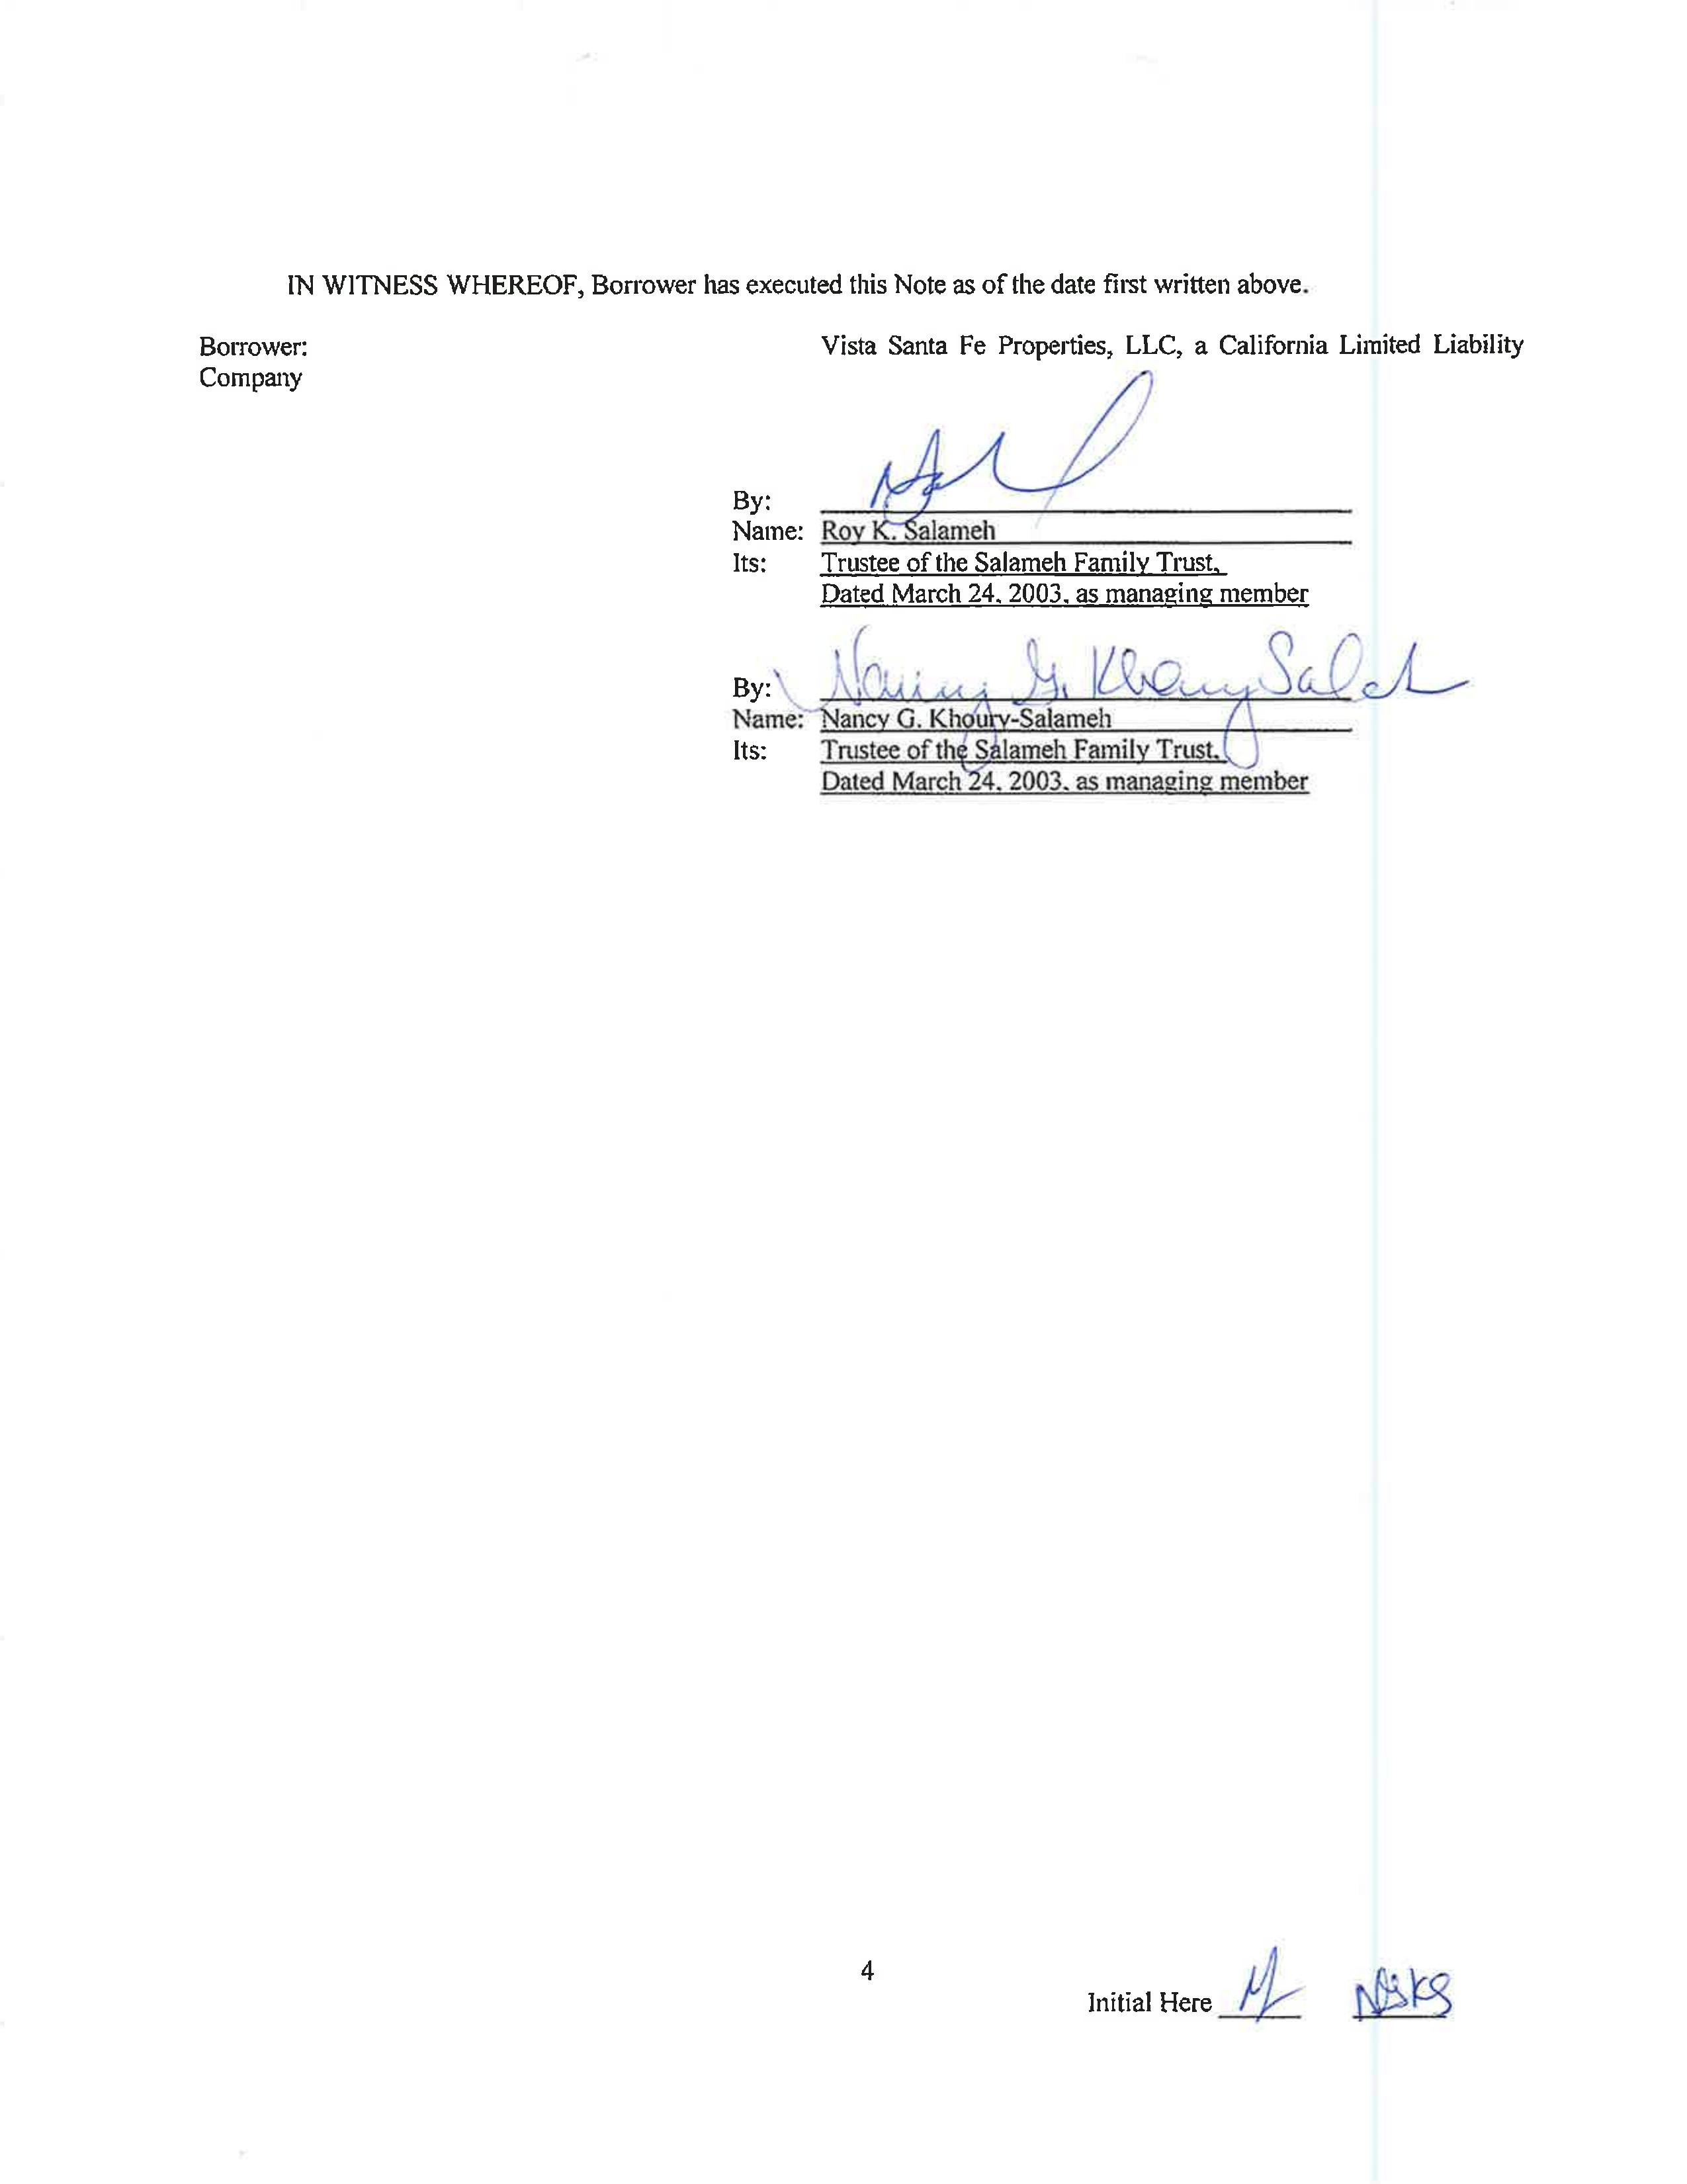

In [23]:
show_images("Handwritten Signature",3)

/content/images/sample-page80.jpg


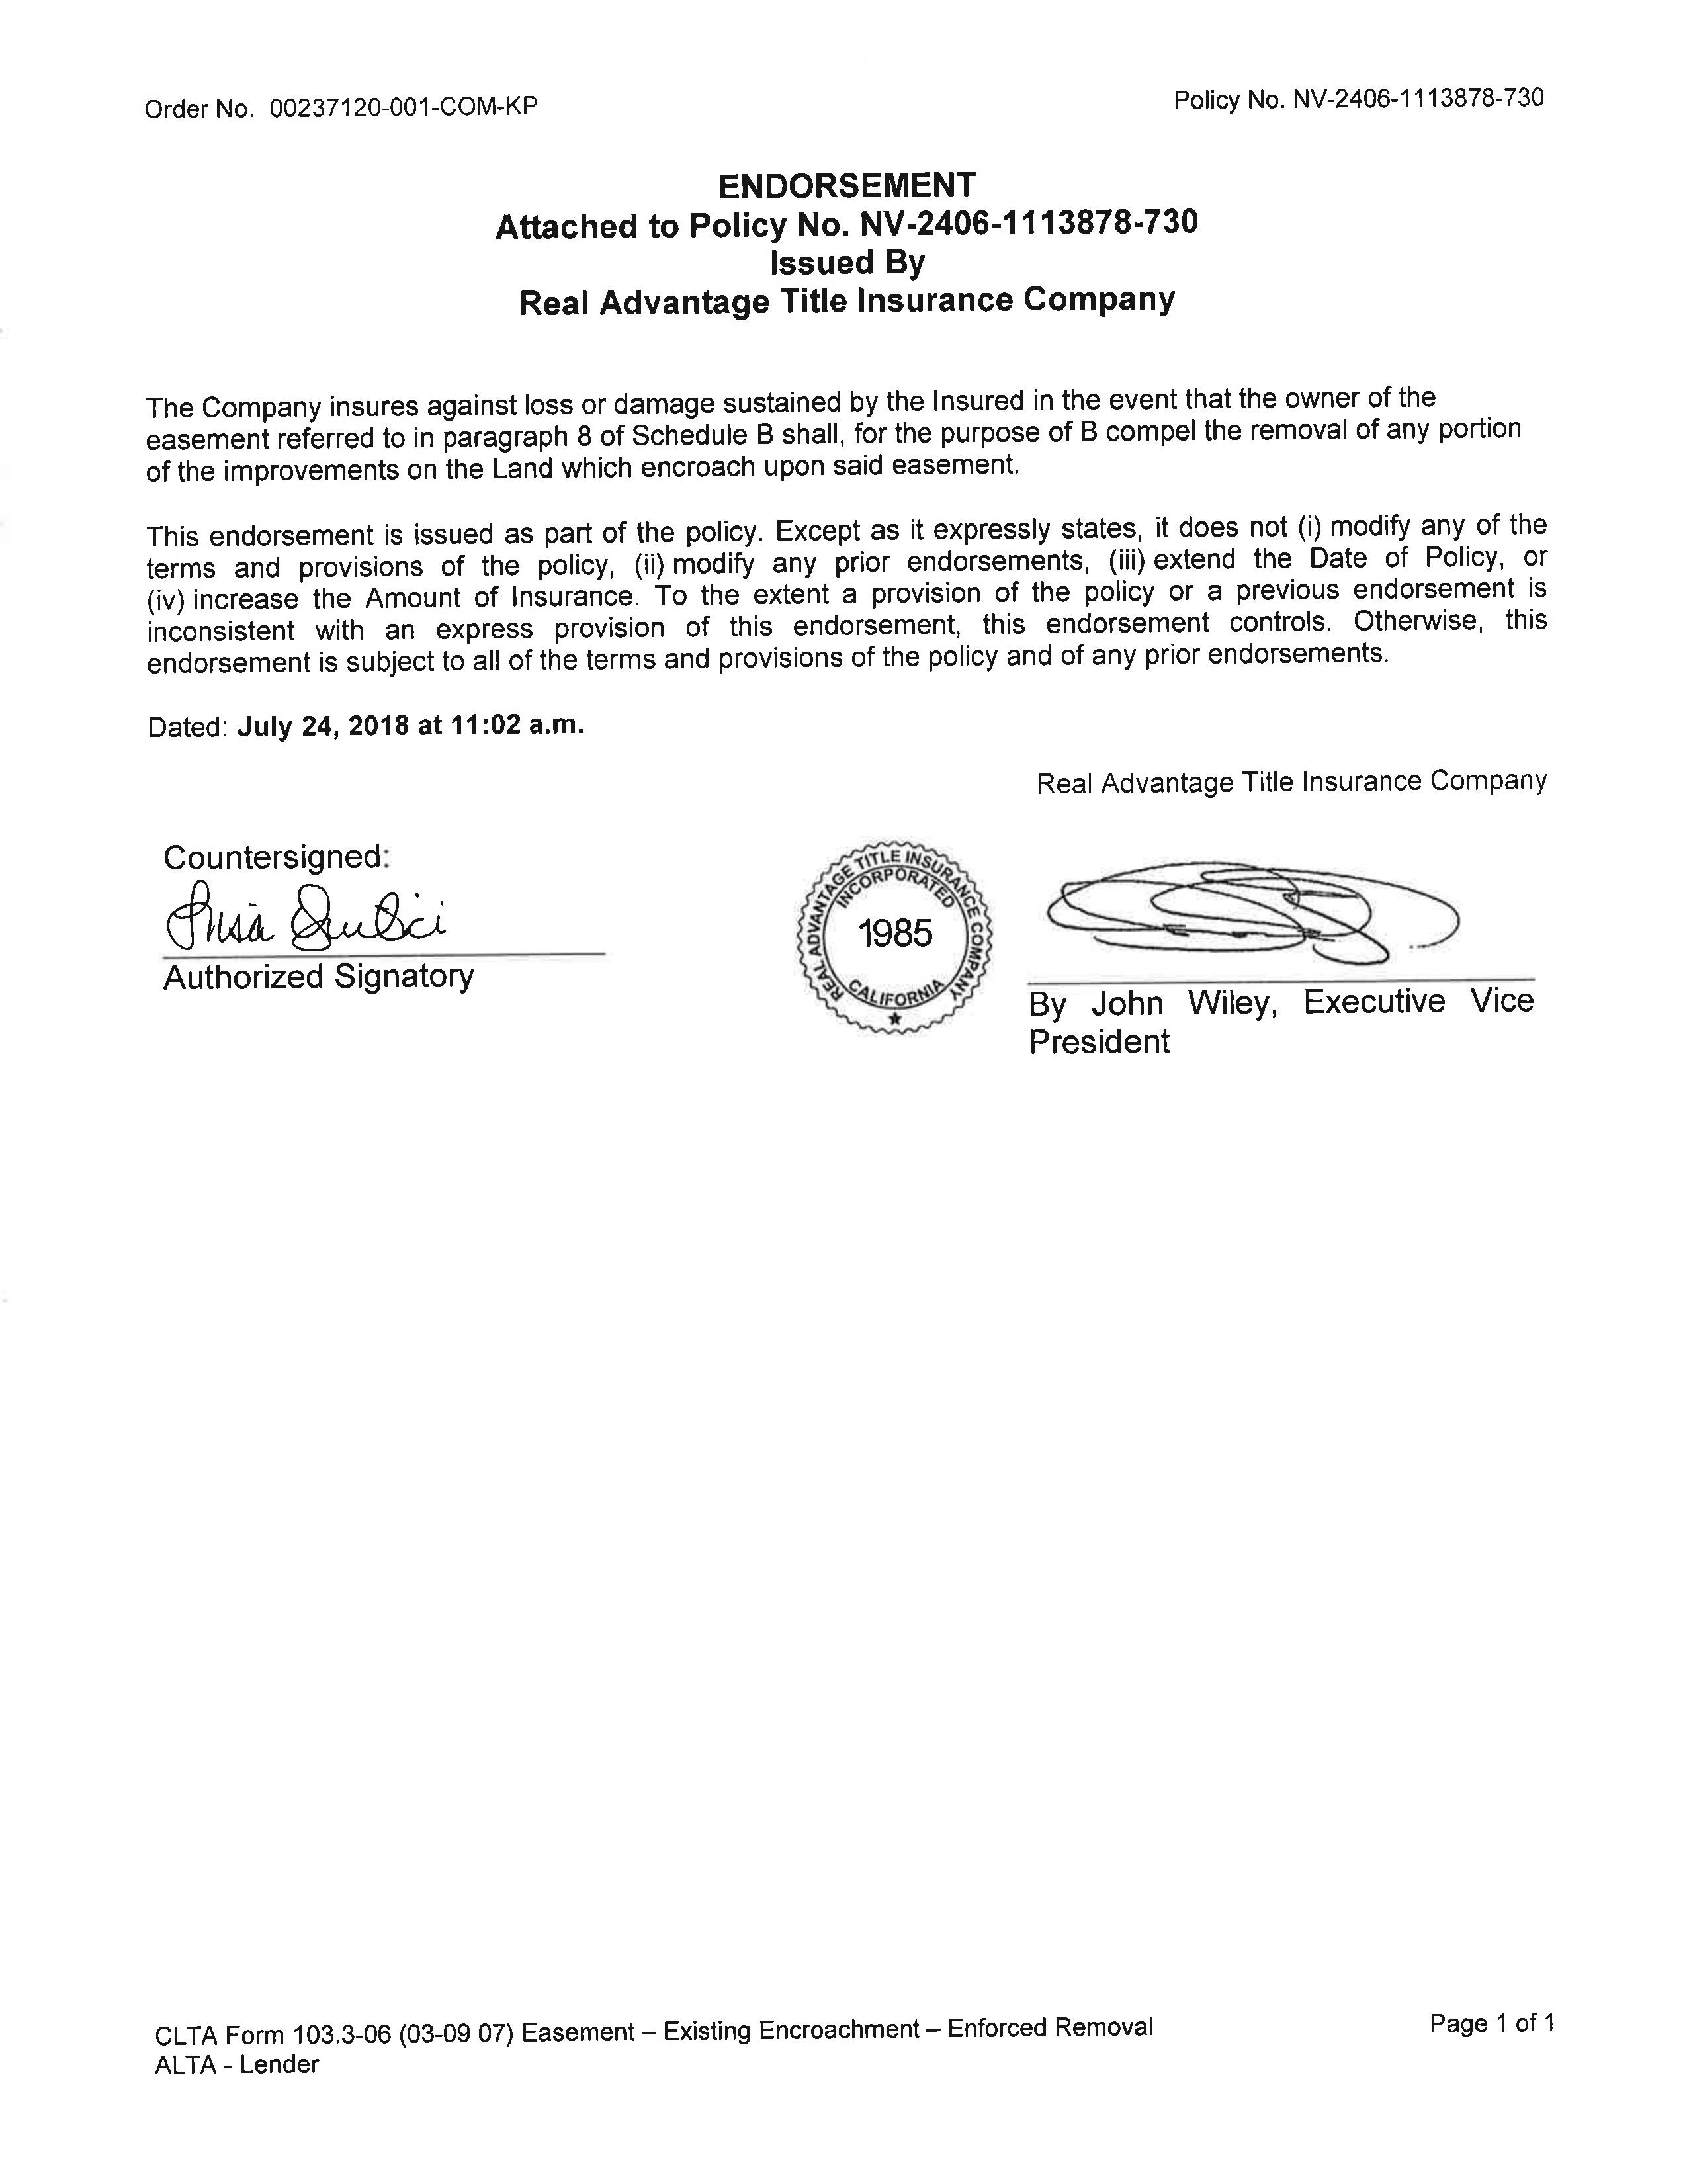

/content/images/sample-page16.jpg


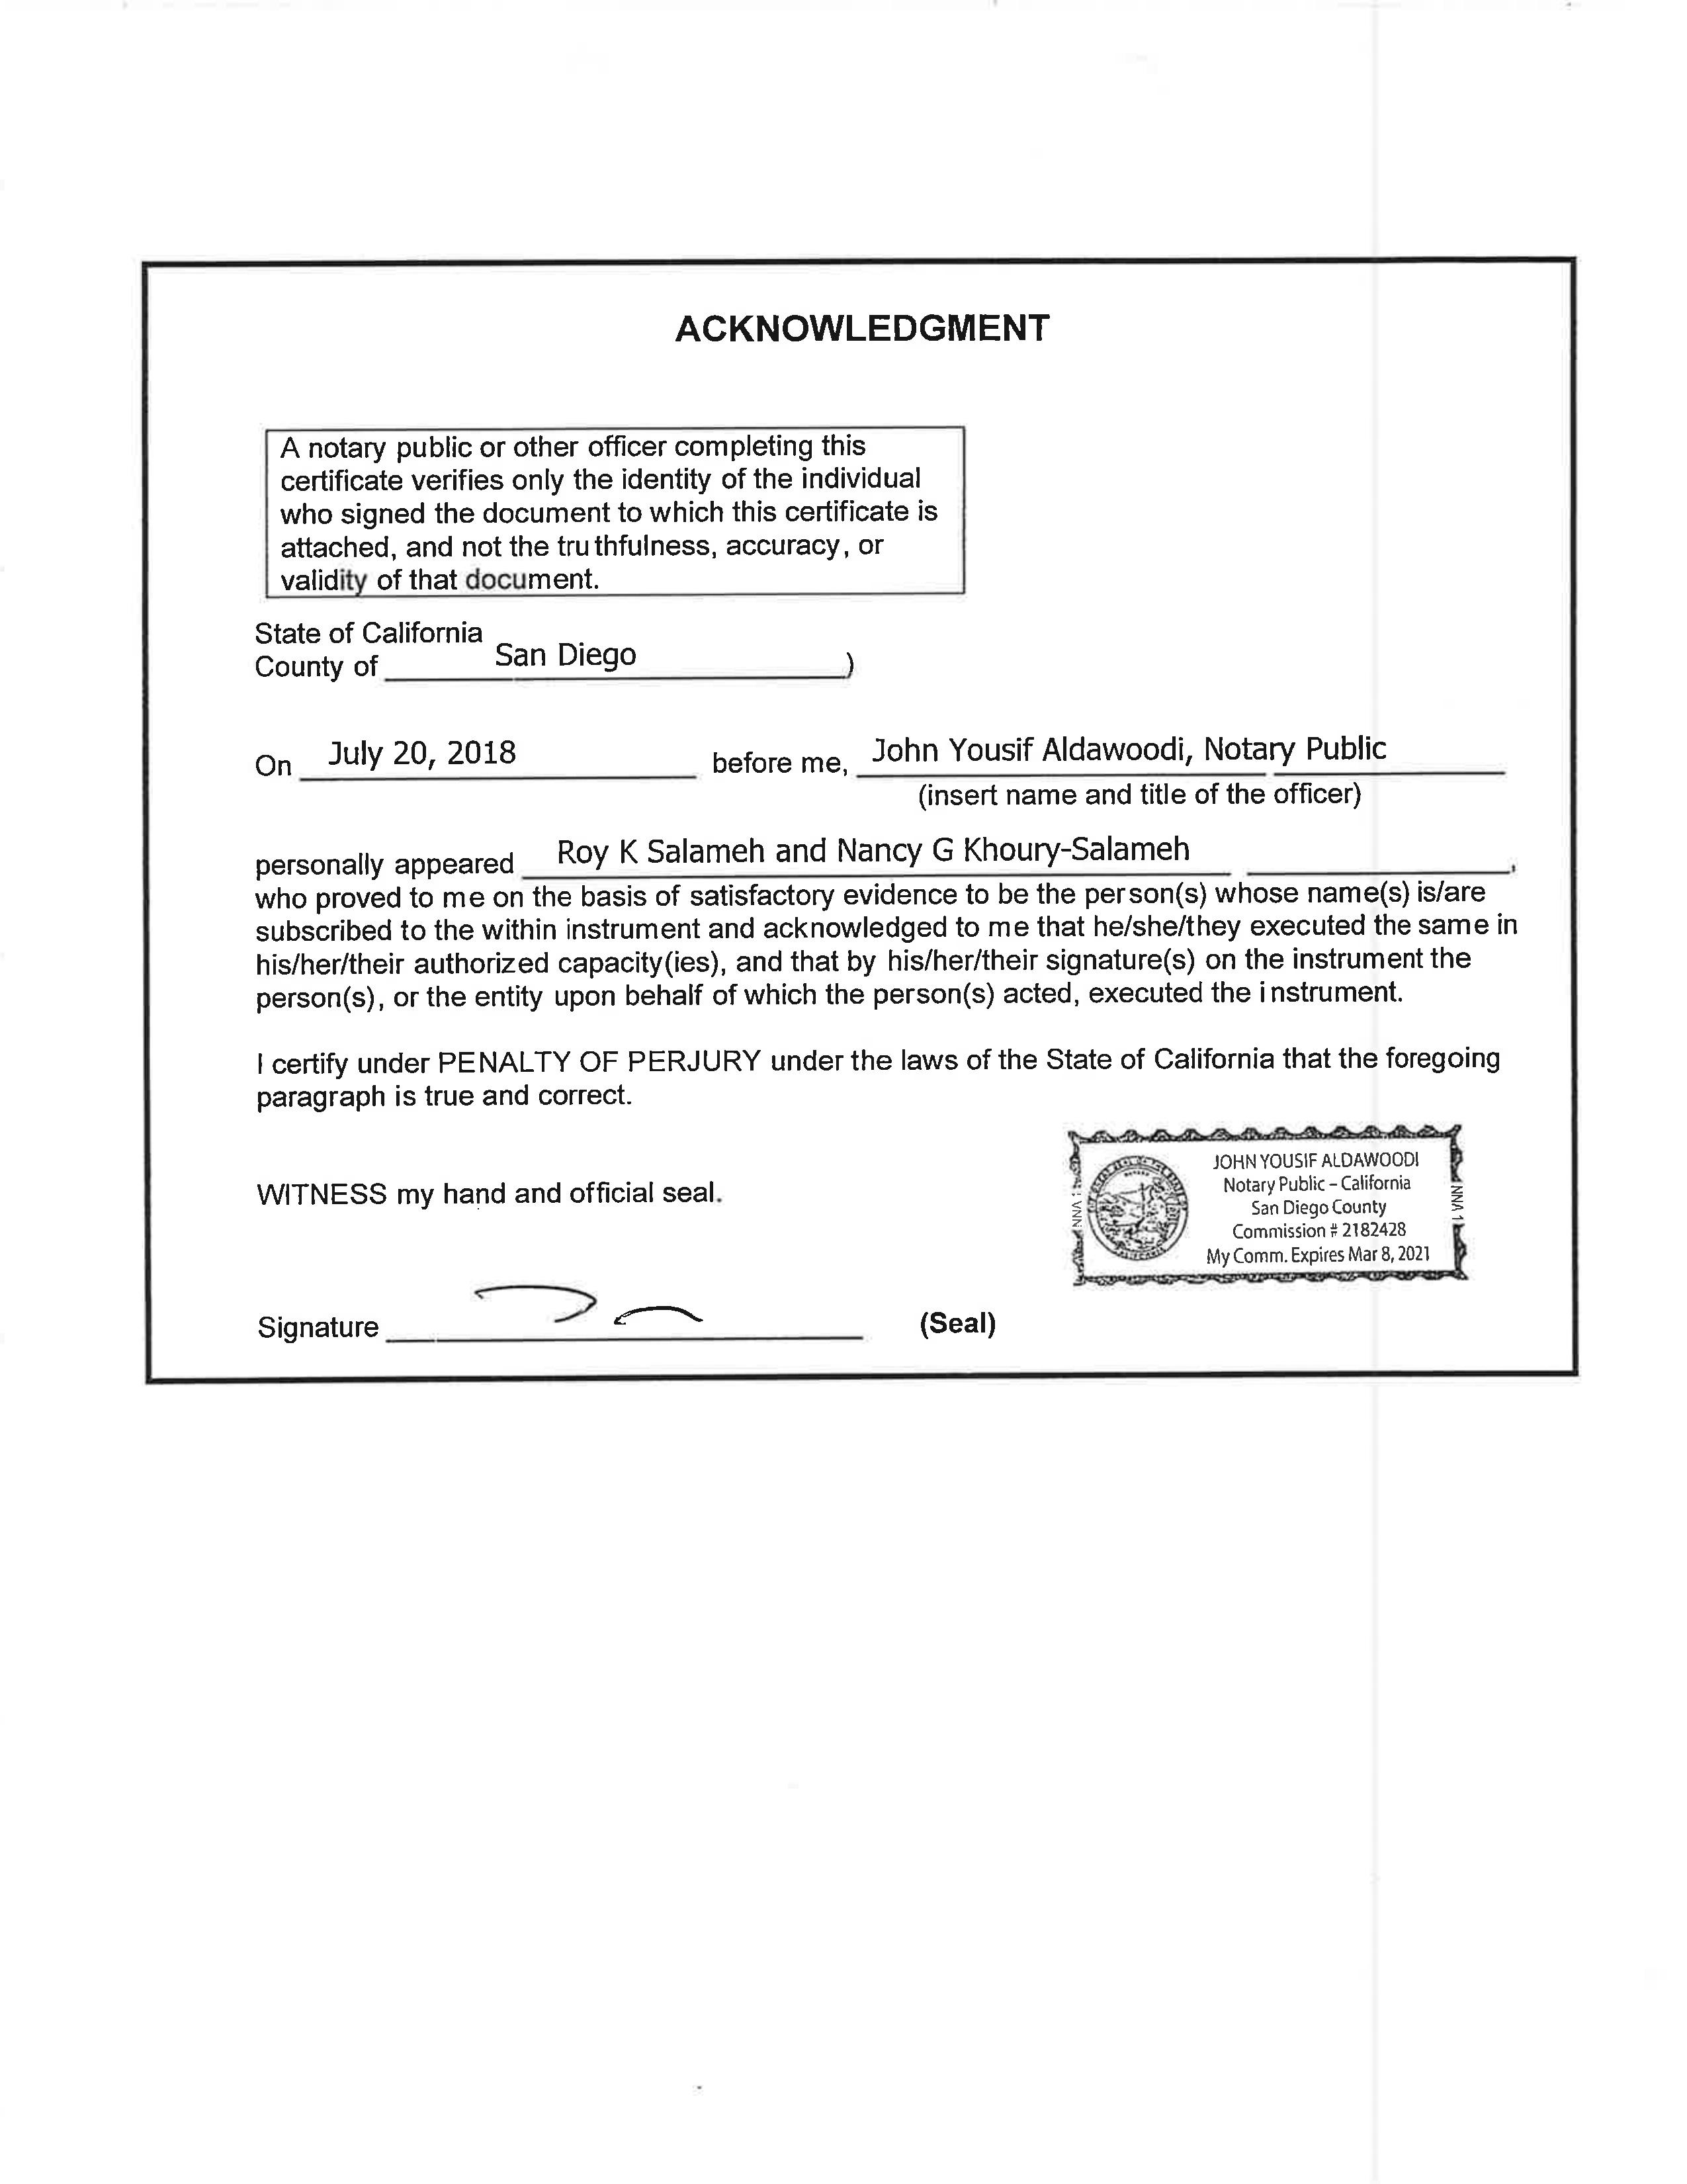

/content/images/sample-page81.jpg


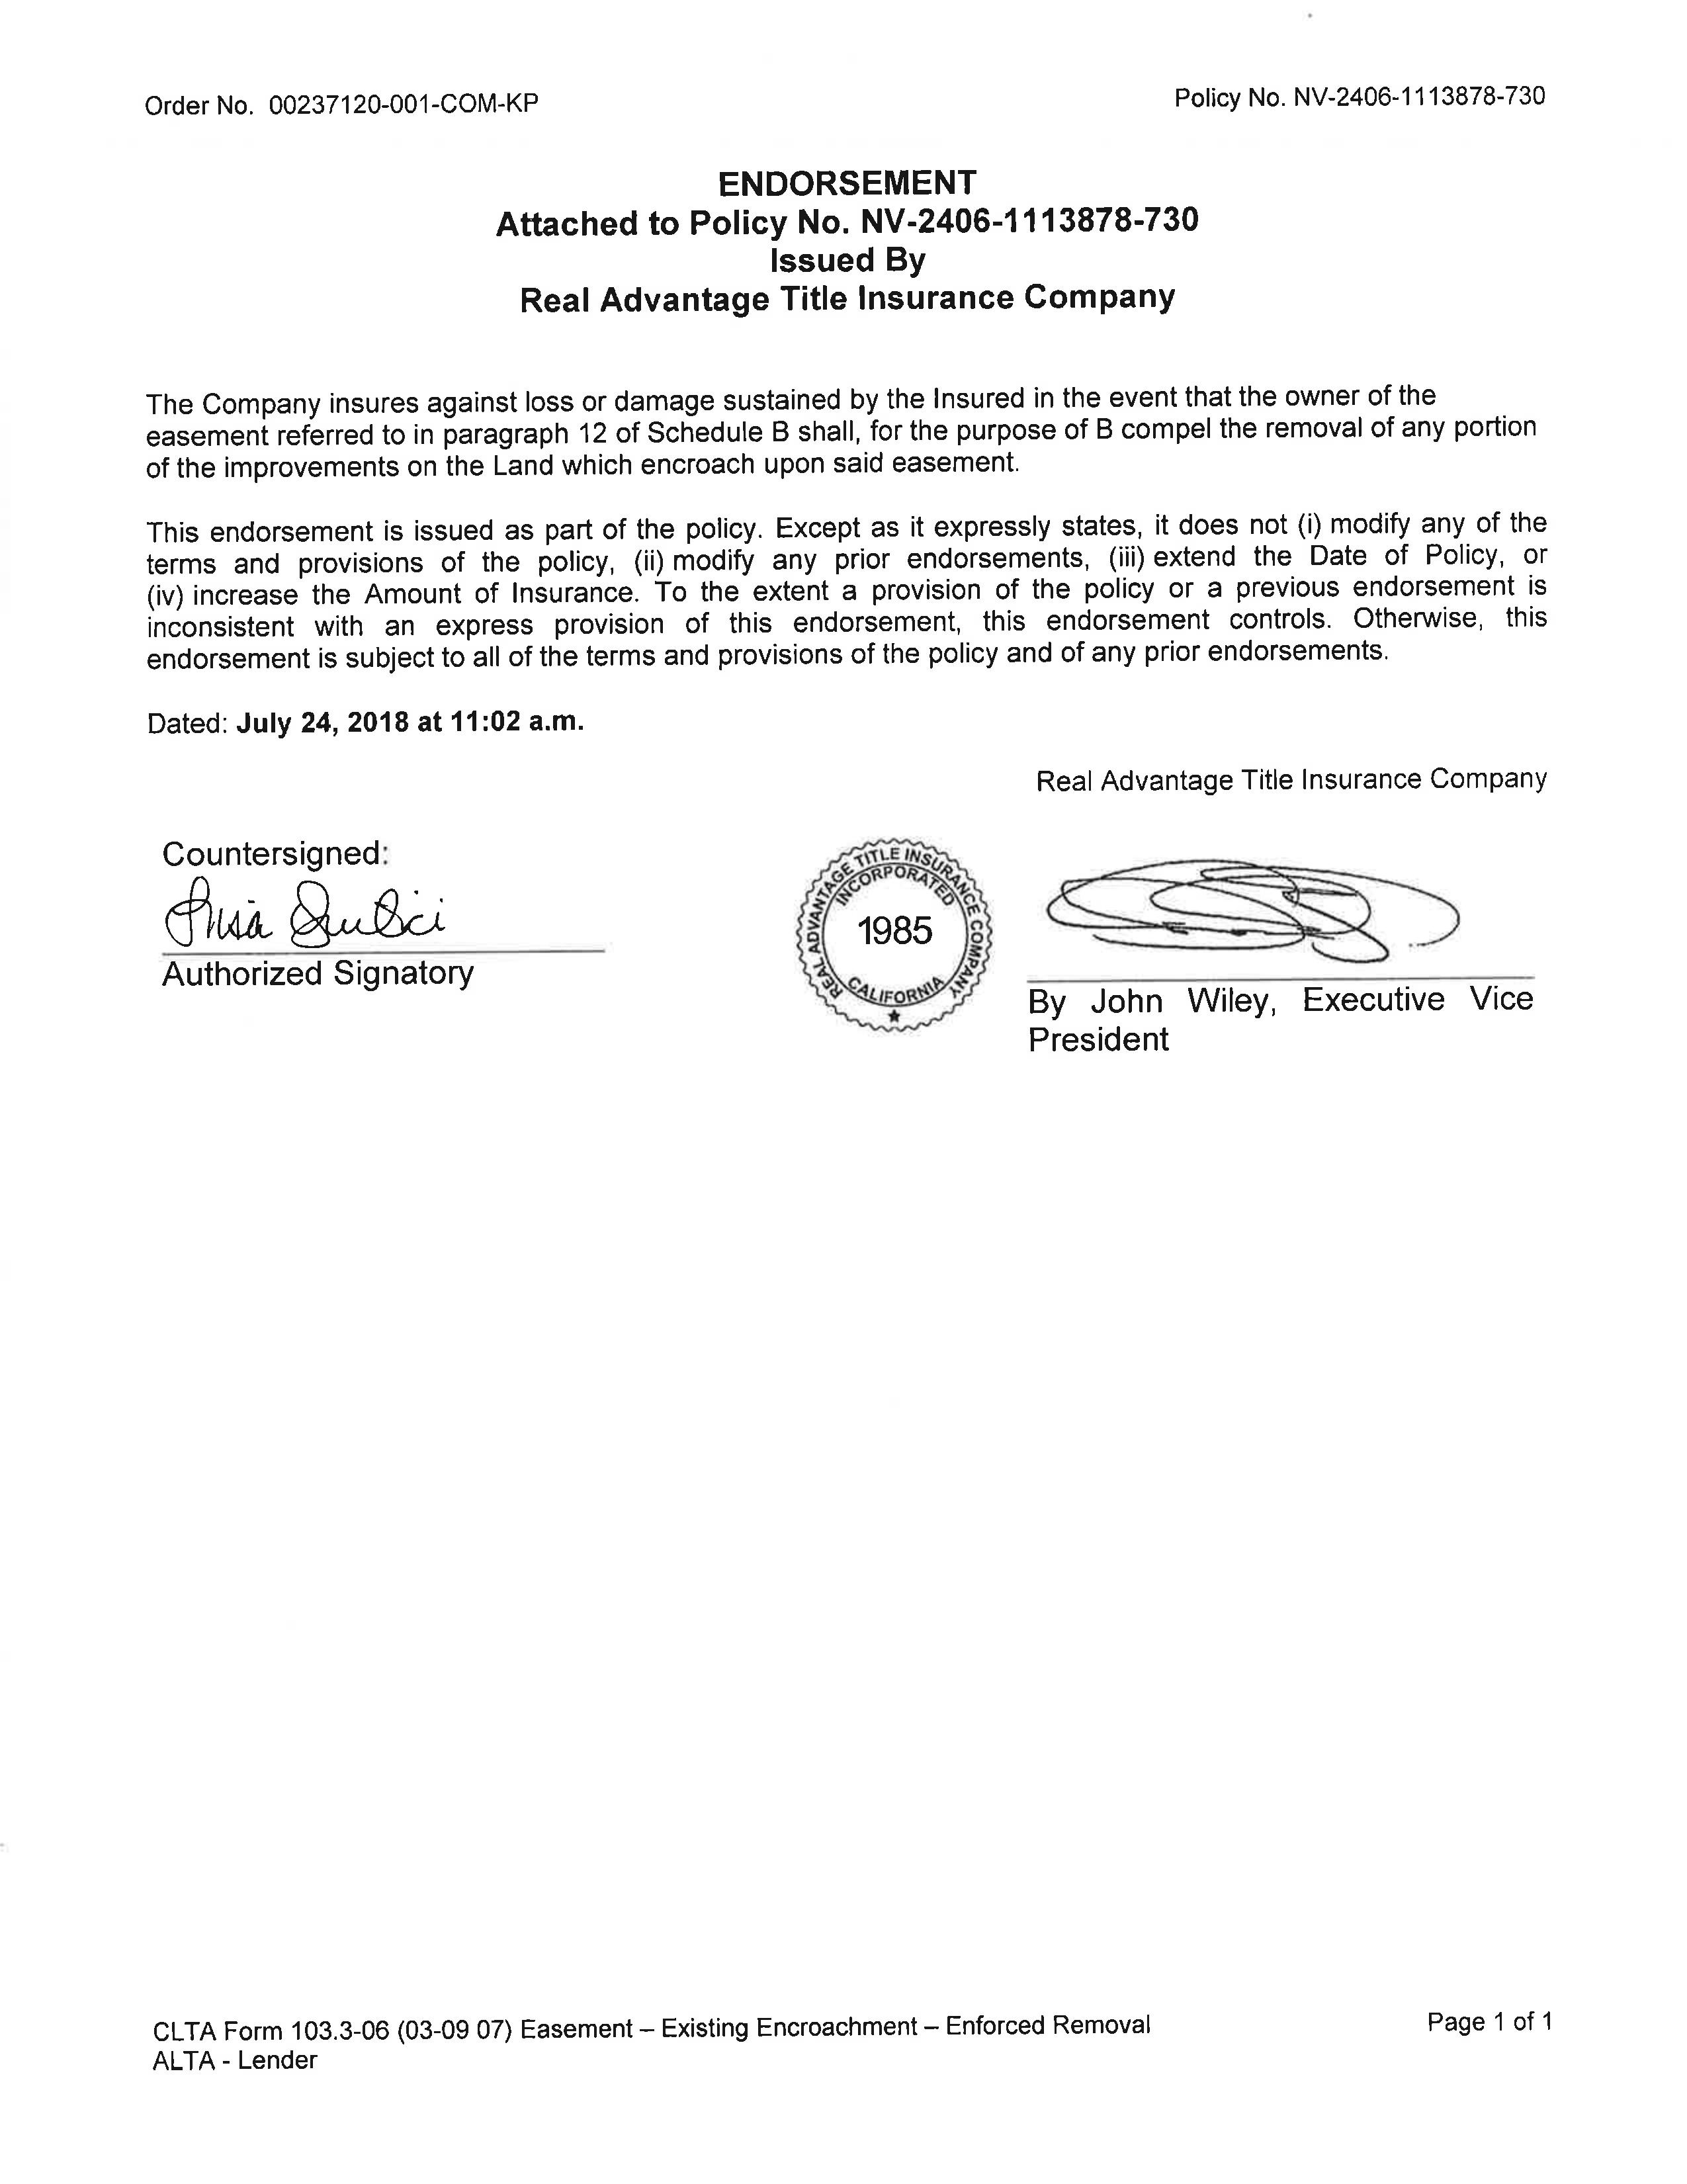

In [24]:
show_images("Notary Seal",3)